In [ ]:
from google.colab import drive
drive.mount ('/content/gdrive', force_remount=True)
# PCam Dataset
!mkdir '/content/train-pcam'
!mkdir '/content/test-pcam'
!unzip -qq '/content/gdrive/MyDrive/train-pcam' -d '/content/train-pcam'
!unzip -qq '/content/gdrive/MyDrive/test-pcam'  -d '/content/test-pcam'
# BreakHis Dataset
!mkdir '/content/bh'
!unzip -qq '/content/gdrive/MyDrive/BreaKHis_v1.zip'  -d '/content/BH'
!unzip -qq '/content/gdrive/MyDrive/Folds.csv.zip'  -d '/content/BH'

Mounted at /content/gdrive


# 1st Phase - Ensemble + Transfer Learning ImageNet - BreakHis

## BH SECTION

### IMPORTING LIBRARIES

In [ ]:
# importing libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf
from functools import partial
# import keras
from tensorflow.keras import layers
import albumentations as A
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold

### GPU CONFIRMATION

In [ ]:
!nvidia-smi

Fri Sep  8 05:00:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### LOADING DATASET

In [ ]:
image_dir = '/content/BH/' #TRAIN_DIR
data_path = '/content/BH/Folds.csv' #TEST_DIR

# experimental API for making data pipelines
tf.data.experimental.AUTOTUNE

# defining the class names
class_names = ['malignant', 'benign']
print(class_names)

['malignant', 'benign']


In [ ]:
# loading the data
data = pd.read_csv(data_path)
data.head(5)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [ ]:
data['fold'].value_counts()

1    7909
2    7909
3    7909
4    7909
5    7909
Name: fold, dtype: int64

### DATA STRUCTURE

In [ ]:
# renaming and structuring the columns for better data understanding
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

In [ ]:
# view first n rows of strucrured data
data.head(6)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png


In [ ]:
data.shape

(39545, 7)

### DATA ANALYSIS

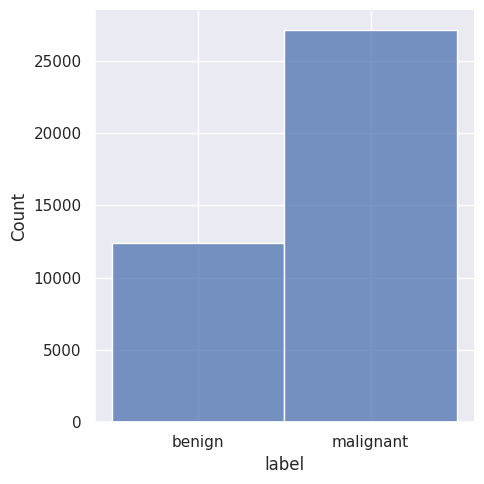

In [ ]:
# making a plot to see data distribution
# sns.figure()
sns.set_theme()
sns.displot(x='label', data=data)

<Axes: xlabel='label', ylabel='count'>

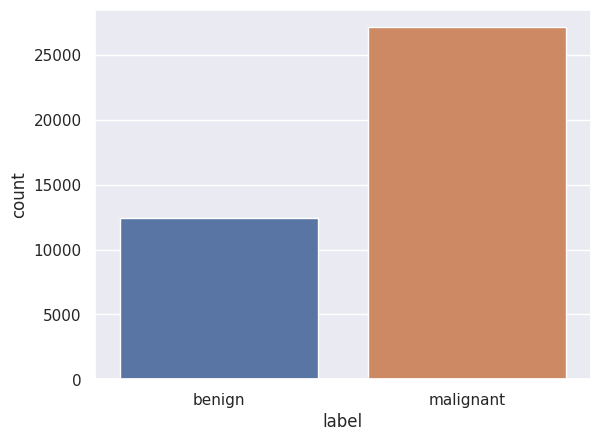

In [ ]:
sns.countplot(x=data['label'], data=data)

### Dataset Modelling for Deep Learning

In [ ]:
# sorting out training, validation and testing images
test_images = data.groupby(by='label').sample(3000)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)

In [ ]:
# making splits of training & validation datasets
validation_images = train_images.sample(frac = 0.3)
train_images = train_images.drop(validation_images.index).reset_index(drop=True)
validation_images = validation_images.reset_index(drop=True)

In [ ]:
print('Total training images: % s' % str(train_images.shape[0]))
print('Total validation images: % s' % str(validation_images.shape[0]))
print('Total testing images: % s' % str(test_images.shape[0]))

Total training images: 23481
Total validation images: 10064
Total testing images: 6000


In [ ]:
train_images['set'] = 'train'
validation_images['set'] = 'validation'
test_images['set'] = 'test'

In [ ]:
new_data = pd.concat([train_images, validation_images, test_images])
new_data.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png,train
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-010.png,train
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-011.png,train
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-012.png,train
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-013.png,train


### Visualizing Train, Validation & Test Splits

<Axes: xlabel='label', ylabel='count'>

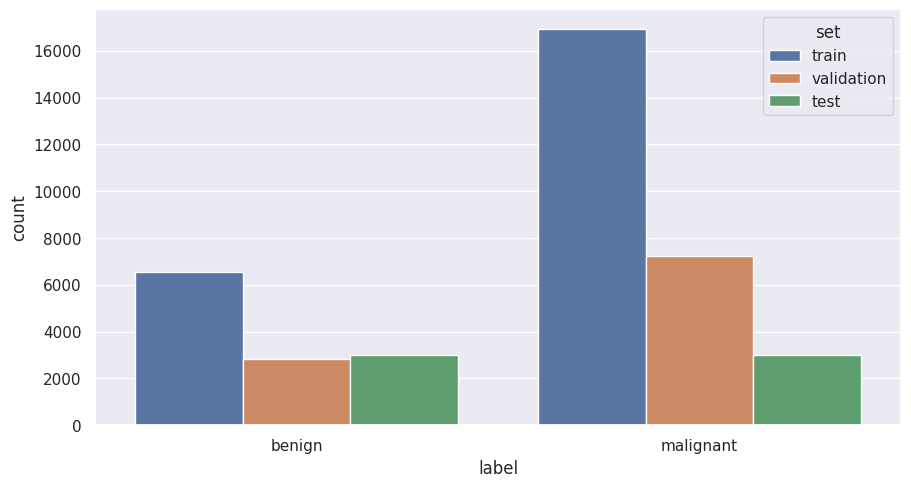

In [ ]:
sns.set(rc={'figure.figsize':(10.4, 5.4)})
sns.countplot(x=new_data['label'], hue=new_data['set'])

### Unsampling Data

In [ ]:
max_count = np.max(train_images.label.value_counts())
min_count = np.min(train_images.label.value_counts())
train_images = train_images.groupby('label').sample(n=max_count, replace=True)
train_images = train_images.reset_index(drop=True)

In [ ]:
train_images.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,3,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_TA-14-16184-200-009.png,train
1,5,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-22704-400-014.png,train
2,5,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-14134E-200-017.png,train
3,4,200,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-22704-200-013.png,train
4,1,40,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-22704-40-034.png,train


## CNN Variables

In [ ]:
# Model Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Variables

kernel_size     = (3,3)
pool_size       = (2,2)
input_shape_bk  = (640, 640, 3) #9109 RGB
input_shape_pc  = (96, 96, 3) #327680 RGB
batch_size      = 32
epochs          = 5
img_size        = 224
num_filters     = 4

first_filters   = 32
second_filters  = 64
third_filters   = 128
fouth_filters   = 256

dropout_conv = 0.3
dropout_dense = 0.3

early_stopping  = EarlyStopping(
        monitor = 'val_acc',
      min_delta = 0.001,
       patience = 5,
        verbose = 1,
           mode = 'auto')

reduce_lr    = ReduceLROnPlateau(
    monitor  ='val_acc',
    factor   = 0.5,
    patience = 2,
    verbose  = 1,
    mode     = 'max',
    min_lr   = 0.00001)

callbacks       = [early_stopping, reduce_lr]

optimizer       = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)                 # SGD(lr=0.001, momentum=0.9), Adam, RMSprop
loss            = 'binary_crossentropy'                      # 'categorical_crossentropy', 'binary_crossentropy'
metric          = 'accuracy'
activation      = 'sigmoid'                                  # 'sigmoid'; 'softmax'
val_split       = 0.2

#SEED           = 1337
#SPLIT_SIZE     = 0.2
#BATCH_SIZE     = 32
#BATCH_SIZE     = 16
#IMAGE_SIZE     = (96,96)
#IMAGE_SIZE     = (224,224)

## Making the Ensemble Deep Learning Model

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
#!pip install -U efficientnet
#import efficientnet.keras as efn

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    #x = Conv2DTranspose(num_filters, (4,4), (2, 2), padding="same")(input)
    x = Conv2DTranspose(num_filters, (3, 2), strides=2, padding="same")(input)
    #x = Conv2DTranspose(num_filters, 3, (2, 2), 'same', use_bias=False)(input)
    #x = Conv2DTranspose(num_filters, (6, 6), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_ensemble_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Ensemble Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    #model = efn.EfficientNetB0(weights='imagenet')  # or weights='noisy-student'
    #efficientNet = efn.EfficientNetB0(include_top=False, weights="imagenet")

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    #s1 = efficientNet.get_layer("stem_conv").output         ## (512 x 512)
    #s2 = efficientNet.get_layer("stem_bn").output         ## (256 x 256)
    #s3 = efficientNet.get_layer("stem_activation").output         ## (128 x 128)
    #s4 = efficientNet.get_layer("block1a_dwconv").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)
    #b1 = efficientNet.get_layer("block1a_bn").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

   # """ Decoder """
   # d1 = decoder_block(b1, s4, 190)                     ## (64 x 64)
   # d2 = decoder_block(d1, s3, 95)                     ## (128 x 128)
   # d3 = decoder_block(d2, s2, 64)                     ## (256 x 256)
   # d4 = decoder_block(d3, s1, 32)                      ## (512 x 512)

    """ Output """
    x = vgg19.layers[-1].output
    #x = efficientNet.layers[-1].output
    # model.layers.pop()
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation=activation)(x)
    #outputs = outputs.shape
    #outputs.shape
    #outputs = layers.Dense(3)(d4)
    #outputs = Conv2D(32, 32, padding="same", activation="sigmoid")(d4)
    #outputs = Conv2D(2, 2, padding="same", activation="sigmoid")(d4)

    print('Output shape: ', output.shape)
    model = Model(inputs, output, name="U-Net_Ensemble")
    return model

if __name__ == "__main__":
    #input_shape = (512, 512, 3)
    #input_shape = input_shape
    model = build_ensemble_unet(input_shape_bk)
    #model.summary()
    print('Input shape: ', input_shape_bk)

#model = build_vgg19_unet((256,256,3))
#model.summary()

80134624/80134624 [==============================] - 5s 0us/step
Output shape:  (None, 1)
Input shape:  (640, 640, 3)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=d134fe1e61eae1a930589f90ac5d9f982d9966b288e3bc4e0119b8d22a399515
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


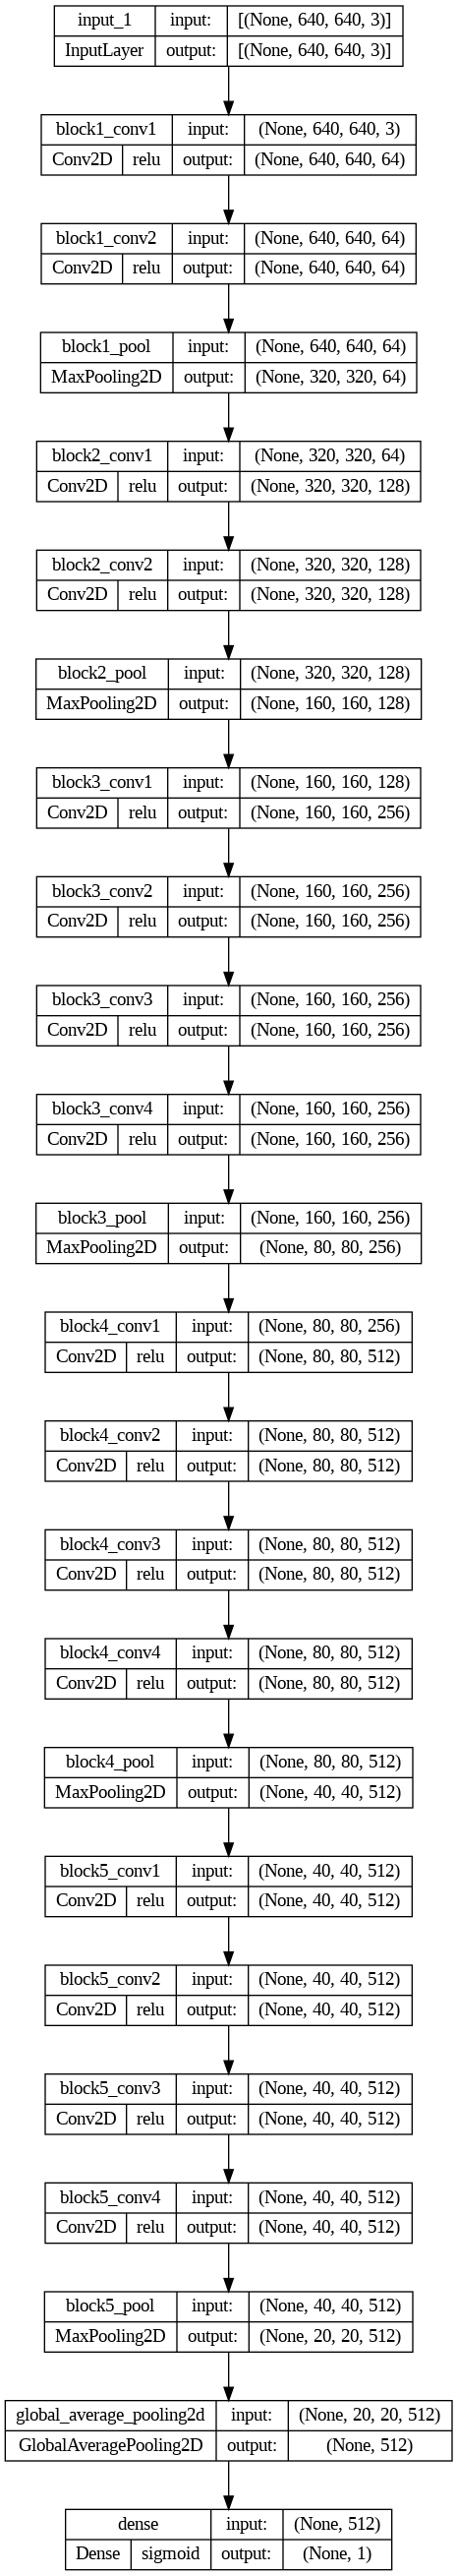

In [ ]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz

# Import necessary libraries
import pandas as pd
import numpy as np                               # Import numpy
from skimage import data, io   # Import skimage library (data - Test images and example data.
#                          io - Reading, saving, and displaying images.)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline
import os                                        # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import cv2 as cv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

## Plot Train Imgs

In [ ]:
#####################  Plot Loss Curves  #####################

def Plot_Train(hlist, start=1):

    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])

    epoch_range = range(start, len(history['loss']) +1)
    s           = slice(start-1, None)
    n           = int(len(history.keys()) / 2)

    plt.figure(figsize=[14,4])
    for i in range(n):
        k = list(history.keys())[i]
        plt.subplot(1, n, i+1)
        plt.plot(epoch_range, history[k][s], label='Training')
        plt.plot(epoch_range, history['val_' + k][s], label='Test')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

## Image Funcs

In [ ]:
# function to decode a PNG image into a tf tensor
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    return image, label

# reshaping the image between 0 and 1
def image_reshape(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224] / 255)
    return image, label

# image argumentation for faster model training
def argument_image(image):
    transform = A.Compose([A.HorizontalFlip(p = 0.5),
                          A.Rotate(p = 0.5, limit = 15),
                          A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1),
                                                    brightness_by_max=True),
                           A.RandomResizedCrop(p=0.8, height=img_size, width=img_size,
                                              scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
                           A.Blur(blur_limit = (1, 1))

                          ])

    data = {"image": image}
    argumented_data = transform(**data)
    argumented_image = argumented_data["image"]
    argumented_image = tf.cast(argumented_image, tf.float32)
    argumented_image = tf.image.resize(argumented_image, [img_size, img_size]) / 255

    return argumented_image

def argumentor_function(image, label):
    argumented_image = tf.numpy_function(func = argument_image, inp=[image], Tout = tf.float32)
    return argumented_image, label


# function to view sample of images
def view_image(ds, col = 5, row = 5, size=(30, 10)):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for images, labels in ds.take(1):
        for i in range(col * row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.tight_layout
    return None


# function for decoding a test image
def decode_test_img(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    #image = tf.image.resize(image, [224, 224])
    image = tf.image.resize(image, [img_size, img_size])
    return image

# def view_model_predictions():
#     plt.figure(figsize = (30, 8))
#     plt.rcParams.update({'font.size': 10})
#     plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
#     for i in range(30):
#         ax = plt.subplot(3, 10, i + 1)
#         shape = str(test_image[i].numpy().shape)
#         plt.imshow(test_image[i].numpy())
#         plt.title(predicted_label[i][0])
#         plt.axis("off")
#         plt.tight_layout
#     return None

# # making a function to calculate & show model history
# def model_hist(history):
#     accuracy = history['accuracy']
#     loss = history['loss']
#     val_accuracy = history['val_accuracy']
#     val_loss = history['val_loss']

#     # setting the epochs
#     n_epochs = range(len(history['loss']))

#     # saving models logs
#     # csv_logger = CSVLogger('cnn_model_logs.csv', append=True)

#     # making plots for accuracy
#     plt.figure(figsize=(16, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(n_epochs, accuracy, label='training accuracy')
#     plt.plot(n_epochs, val_accuracy, label='validation accuracy')
#     plt.legend()

#     # making plots for loss
#     plt.figure(figsize=(16, 5))
#     plt.subplot(1, 2, 2)
#     plt.plot(n_epochs, loss, label='training loss (binary crossentropy)')
#     plt.plot(n_epochs, val_loss, label='validation loss (binary crossentropy)')
#     plt.legend()

#     return None

    # function for building a NN
#def make_nn_model(image_size):
#    print('Making our deep cnn model.....')
#    cnn_model = tf.keras.Sequential([
#        layers.InputLayer(input_shape=(image_size, image_size, 3)),
#        hub.KerasLayer(model_handle, trainable=True, name='base'),
    #     layers.Dense(512, activation='relu', name='fc1'),
    #     layers.BatchNormalization(),
    #     layers.Dropout(0.4, name='dropout'),
    #     layers.Dense(128, activation='relu', name='fc2'),
    #     layers.BatchNormalization(),
    #     # layers.Dropout(0.4, name='dropout2'),
    #     layers.Dense(1, activation='sigmoid', name='output')
    # ], name=model_name)

    # cnn_model.build((None, image_size, image_size, 3))
    # cnn_model.summary()
    # print('model built!')
    # return cnn_model

### Model Configuration Parameters

### Loading the Dataset

In [ ]:
image_dir = "/content/BH/"
(image_dir + train_images.path)[0]
print(train_images.path)
print(image_dir)

0        BreaKHis_v1/histology_slides/breast/benign/SOB...
1        BreaKHis_v1/histology_slides/breast/benign/SOB...
2        BreaKHis_v1/histology_slides/breast/benign/SOB...
3        BreaKHis_v1/histology_slides/breast/benign/SOB...
4        BreaKHis_v1/histology_slides/breast/benign/SOB...
                               ...                        
33833    BreaKHis_v1/histology_slides/breast/malignant/...
33834    BreaKHis_v1/histology_slides/breast/malignant/...
33835    BreaKHis_v1/histology_slides/breast/malignant/...
33836    BreaKHis_v1/histology_slides/breast/malignant/...
33837    BreaKHis_v1/histology_slides/breast/malignant/...
Name: path, Length: 33838, dtype: object
/content/BH/


In [ ]:
# loading the train & validation datasets
load_train = tf.data.Dataset.from_tensor_slices((image_dir + "/" + train_images.path,
                                                train_images.label_int))

load_valid = tf.data.Dataset.from_tensor_slices((image_dir + "/" + validation_images.path,
                                                validation_images.label_int))

In [ ]:
load_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_dataset = (
                load_train.shuffle(len(train_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )
val_dataset = (
                load_valid.shuffle(len(validation_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# checking the path of images
train_images.path[5]

'BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-025.png'

### Deep Learning Model Training Using K Fold Cross Validation

In [ ]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels
get_labels_from_tfdataset(train_dataset)

<tf.Tensor: shape=(33838,), dtype=int64, numpy=array([1, 0, 0, ..., 1, 0, 0])>

### Twersky Loss Func

In [ ]:
# TRAINING MODEL UNET -> -> VGG19
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

## 1st Train Ensemble

In [ ]:
start = time.time()
# starting a new sesion for TF
from keras import backend as K

tf.keras.backend.clear_session()

# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_ensemble_1st_train.h5', save_best_only=True)

# model logs
csv_logger = CSVLogger('cnn_model_logs.csv', append=True)

metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]
#metrics = [tversky]
# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
#model.compile(loss=focal_tversky, optimizer='adam', metrics=[tversky])

# fit the model
train_history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size, verbose=1,
                             callbacks=[model_checkpoint, csv_logger], validation_data=val_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Epoch 1/5
 332/1058 [========>.....................] - ETA: 1:44 - loss: 0.8132 - accuracy: 0.4949 - Precision: 0.4900 - Recall: 0.4459

KeyboardInterrupt: ignored

### 1st Model Results

In [ ]:
# visualize model performance
history = train_history.history
print(model.metrics_names)
#model_hist(history)

In [ ]:
print('Net loss on validation data: %.3f' % model_performance[0])
print('Net accuracy on validation data: %.3f' % model_performance[1])
#print('Net precision on validation data: %.3f' % model_performance[2])
#print('Net recall on validation data: %.3f' % model_performance[3])

In [ ]:
print('Total Test Images: %d' % len(test_images))

In [ ]:
test_index = test_images.label_int.values
test_labels = test_images.label.values
test_index, test_labels

In [ ]:
# making samples of test data
test_images = test_images.sample(frac=1).reset_index(drop=True)
test_data = tf.data.Dataset.from_tensor_slices(image_dir + test_images.path)
test_data = test_data.map(decode_test_img,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
test_data

In [ ]:
model.compile(loss=focal_tversky, optimizer='adam', metrics=[tversky])
model_performance = model.evaluate(test_data)

In [ ]:
test_image = next(iter(test_data))

In [ ]:
test_predictions = model.predict(test_data)
predicted_index = np.round(test_predictions)

In [ ]:
predicted_index[:6]

In [ ]:
predicted_index = np.round(test_predictions).astype(int)
predicted_label = np.array(class_names)[predicted_index]
predicted_label[:8]

In [ ]:
prediction_data = pd.DataFrame({'filename':test_images.filename.values,'actual':test_images.label.values,
                              'prediction': np.squeeze(predicted_label),'path':test_images.path.values,})

In [ ]:
# see model predictions
prediction_data[['actual', 'prediction']].head(15)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=test_index, y_pred=predicted_index)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
vis.plot()
plt.show()

## 2nd Phase - Ensemble + Transfer Learning ImageNet - BreakHis - PathCam

In [ ]:
#from google.colab import drive

#drive.mount ('/content/gdrive', force_remount=True)

DB_PATH   = '/content/'
TRAIN_DIR = DB_PATH +'train-pcam/'
TEST_DIR  = DB_PATH + 'test-pcam/'
DIR       = ['train-pcam/', 'test-pcam/']

## Load Dataframes

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/train_labels.csv',dtype=str)
train_df.id = train_df.id + '.tif'

In [ ]:
#image_dir = '../input/breakhis/BreaKHis_v1/'
#data_path = '../input/breakhis/Folds.csv'

# experimental API for making data pipelines
tf.data.experimental.AUTOTUNE

# defining the class names
class_names = ['malignant', 'benign']
print(class_names)

In [ ]:
print('Train Shape: ' , train_df.shape)
train_df.head()

In [ ]:
(train_df.label.value_counts() / len(train_df)).to_frame().sort_index().T

In [ ]:
train_df.dtypes

## LOADING TRAIN/TEST DATASET

In [ ]:
train_images = '/content/gdrive/MyDrive/train-pcam'
test_images = '/content/gdrive/MyDrive/test_pcam'

In [ ]:
train_dataset = (
                load_train.shuffle(len(train_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )
val_dataset = (
                load_valid.shuffle(len(validation_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

In [ ]:
train_dataset

In [ ]:
val_dataset

## Preprocessing and Generate the Dataset

### Preprocessing

In [ ]:
#Check for image string

img = TRAIN_DIR + train_df.id[5]
fobj = open(img, "rb")
fobj.peek(10)

In [ ]:
# plot few Train images
from cv2 import imread

sample = train_df.sample(n=18).reset_index()
plt.figure(figsize=(10,10))
plt.suptitle('Histopathologic scans of lymph node sections',fontsize=16)
for i, row in sample.iterrows():
    img = imread(TRAIN_DIR + f'{row.id}')
    label = row.label

    plt.subplot(6,6,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)


# Negatives
for i, idx in enumerate(train_df[train_df['label'] == '0']['id'][:5]):
    path = os.path.join(TRAIN_DIR, idx)
    img = imread(path)
    ax[0,i].imshow(img)
ax[0,0].set_ylabel('Negative samples', size='large')


# # Positives
for i, idx in enumerate(train_df[train_df['label'] == '1']['id'][:5]):
    path = os.path.join(TRAIN_DIR, idx)
    img = imread(path)
    ax[1,i].imshow(img)
ax[1,0].set_ylabel('Positive samples', size='large');

In [ ]:
train_df.head()

## Ensemble Deep Learning Architecture (DTL)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
#!pip install -U efficientnet
#import efficientnet.keras as efn

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    #x = Conv2DTranspose(num_filters, (4,4), (2, 2), padding="same")(input)
    x = Conv2DTranspose(num_filters, (3, 2), strides=2, padding="same")(input)
    #x = Conv2DTranspose(num_filters, 3, (2, 2), 'same', use_bias=False)(input)
    #x = Conv2DTranspose(num_filters, (6, 6), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_ensemble_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Ensemble Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    #model = efn.EfficientNetB0(weights='imagenet')  # or weights='noisy-student'
    #efficientNet = efn.EfficientNetB0(include_top=False, weights="imagenet")

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    #s1 = efficientNet.get_layer("stem_conv").output         ## (512 x 512)
    #s2 = efficientNet.get_layer("stem_bn").output         ## (256 x 256)
    #s3 = efficientNet.get_layer("stem_activation").output         ## (128 x 128)
    #s4 = efficientNet.get_layer("block1a_dwconv").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)
    #b1 = efficientNet.get_layer("block1a_bn").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

   # """ Decoder """
   # d1 = decoder_block(b1, s4, 190)                     ## (64 x 64)
   # d2 = decoder_block(d1, s3, 95)                     ## (128 x 128)
   # d3 = decoder_block(d2, s2, 64)                     ## (256 x 256)
   # d4 = decoder_block(d3, s1, 32)                      ## (512 x 512)

    """ Output """
    x = vgg19.layers[-1].output
    #x = efficientNet.layers[-1].output
    # model.layers.pop()
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation=activation)(x)
    #outputs = outputs.shape
    #outputs.shape
    #outputs = layers.Dense(3)(d4)
    #outputs = Conv2D(32, 32, padding="same", activation="sigmoid")(d4)
    #outputs = Conv2D(2, 2, padding="same", activation="sigmoid")(d4)

    print('Output shape: ', output.shape)
    model = Model(inputs, output, name="U-Net_Ensemble")
    return model

if __name__ == "__main__":
    #input_shape = (512, 512, 3)
    #input_shape = input_shape
    model = build_ensemble_unet(input_shape_pc)
    #model.summary()
    print('Input shape: ', input_shape_pc)

#model = build_vgg19_unet((256,256,3))
#model.summary()

## Arch Visualization

In [ ]:
#!pip install visualkeras
#!pip install ann_visualizer
#!pip install graphviz

# Import necessary libraries
import pandas as pd
import numpy as np                               # Import numpy
from skimage import data, io   # Import skimage library (data - Test images and example data.
#                          io - Reading, saving, and displaying images.)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline
import os                                        # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import cv2 as cv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

## DTL TRAIN

In [ ]:
start = time.time()
# starting a new sesion for TF
from keras import backend as K

#image_size = 224
tf.keras.backend.clear_session()

# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_ensemble_DTL_train.h5', save_best_only=True)

# load weights from the first model
model.load_weights("model_ensemble_1st_train.h5")

# model logs
csv_logger = CSVLogger('cnn_model_logs.csv', append=True)

#metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]
metrics = [tversky]
# compiling the model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
model.compile(loss=focal_tversky, optimizer='adam', metrics=[tversky])

# fit the model
train_history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size, verbose=1,
                             callbacks=[model_checkpoint, csv_logger], validation_data=val_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

## DTL Results

In [ ]:
# visualize model performance
history = train_history.history
model_hist(history)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

#xpred =

## Classification Report

In [ ]:
# loading the data
data_path = '/content/gdrive/MyDrive/train_labels.csv'
data = pd.read_csv(data_path)
data.head(5)

In [ ]:
# sorting out training, validation and testing images
test_images = data.groupby(by='label').sample(3000)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)
test_images

In [ ]:
# renaming and structuring the columns for better data understanding
data = data.rename(columns={'id': 'path'})
#data['label'] = data.path.apply(lambda x: x.split('/')[1])
#data['label_int'] = data.label.apply(lambda x: class_names.index(x))
#data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

data.head(5)

len(data)

In [ ]:
validation_images = train_images.sample(frac = 0.3)
train_images = train_images.drop(validation_images.index).reset_index(drop=True)
validation_images = validation_images.reset_index(drop=True)

train_images['set'] = 'train'
validation_images['set'] = 'validation'
test_images['set'] = 'test'

validation_images

## Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = get_labels_from_tfdataset(val_dataset)
ypred = model_nn.predict(val_dataset)
y_pred = np.where(ypred > 0.3, 1, 0)
cm = confusion_matrix(labels, y_pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=labels, y_pred=y_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
vis.plot()
plt.show()

# 1st Phase - VGG16 + Transfer Learning ImageNet - BreakHis

In [ ]:
import keras

### Building the Base Model vgg16

train_steps = np.ceil(len(train_dataset) / batch_size)
val_steps = np.ceil(len(val_dataset) / batch_size)

print('Steps:')
print('Train: %d | Validation: %d ' %(train_steps, val_steps))

input_shape = (640, 640, 3)
def model_vgg16(input_shape, activation):

    model = tf.keras.applications.vgg16.VGG16(
        input_shape   = input_shape,
        include_top   = False,
        weights = 'imagenet')

    x = model.layers[-1].output
    # model.layers.pop()
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation=activation)(x)
    print('Output shape: ', output.shape)
    model.trainable = False
    model = keras.Model(inputs=model.input, outputs=output)

    return model

if __name__ == "__main__":
    #input_shape = (512, 512, 3)
    #input_shape = input_shape
    model = model_vgg16(input_shape, activation)
    model.summary()
    print('Input shape: ', input_shape)

Steps:
Train: 34 | Validation: 10 
Output shape:  (None, 1)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 640, 640, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 640, 640, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 320, 320, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 320, 320, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 320, 320, 128)     147584    
                                                                 

## 1st Train VGG16

In [ ]:
model_vgg16 = model_vgg16(input_shape, activation)
model_vgg16.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])

s = time.time()
# with tf.device('/CPU:0'):              # Running on CPU
vgg16 = model_vgg16.fit(train_dataset, epochs=epochs, batch_size=batch_size, verbose=1,
                             callbacks=[model_checkpoint, csv_logger], validation_data=val_dataset)
#vgg16 = model_vgg16.fit(x                = train_gen,
#                   steps_per_epoch  = train_steps,
#                   validation_data  = valid_gen,
#                   validation_steps = val_steps,
 #                  epochs           = epochs)

#vgg16 = model_vgg16.fit(x           = train_dataset,
                   #steps_per_epoch  = train_steps,
#                   validation_data  = val_dataset,
                   #validation_steps = val_steps,
#                   epochs           = epochs)


print('Fitting model in %.2f secs' % (time.time()-s))

# pickle.dump(h3, open(f'HCDmVGG16.pkl', 'wb'))

# with open(DB_PATH 'HCDmVGG16.pkl', 'wb') as file_pkl:
#     pickle.dump(history.history, file_pkl)


## VGG-16 Results

In [ ]:
Plot_Train([vgg16])

## Conf Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = get_labels_from_tfdataset(train_dataset)
ypred = model_vgg16.predict(valid_gen)
y_pred = np.where(ypred > 0.5, 1, 0)
cm = confusion_matrix(labels, y_pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=labels, y_pred=y_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
vis.plot()
plt.show()

## VGG-19 - Build

In [ ]:
### Building the Base Model vgg19
def model_vgg19(input_shape, activation):

    #model = tf.keras.applications.vgg16.VGG16(
    model = tf.keras.applications.vgg19.VGG19(

        input_shape   = input_shape,
        include_top   = False,
        weights = 'imagenet')

    x = model.layers[-1].output
    # model.layers.pop()
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation=activation)(x)
    model.trainable = False
    model = keras.Model(inputs=model.input, outputs=output)

    return model

    if __name__ == "__main__":
    #input_shape = (512, 512, 3)
    #input_shape = input_shape
      model = model_vgg19(input_shape, activation)
      model.summary()
      print('Input shape: ', input_shape)

## VGG-19 TRAIN

In [ ]:
model_vgg19 = model_vgg19(input_shape, activation)
model_vgg19.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])

s = time.time()
# with tf.device('/CPU:0'):              # Running on CPU
vgg19 = model_vgg19.fit(x                = train_dataset,
                   #steps_per_epoch  = train_steps,
                   validation_data  = val_dataset,
                   #validation_steps = val_steps,
                   epochs           = epochs)

print('Fitting model in %.2f secs' % (time.time()-s))

# pickle.dump(h3, open(f'HCDmVGG16.pkl', 'wb'))

# with open(DB_PATH 'HCDmVGG16.pkl', 'wb') as file_pkl:
#     pickle.dump(history.history, file_pkl)


## VGG-19 - Results

In [ ]:
Plot_Train([vgg19])

## Conf Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = get_labels_from_tfdataset(val_dataset)
ypred = vgg_19.predict(val_dataset)
y_pred = np.where(ypred > 0.5, 1, 0)
cm = confusion_matrix(labels, y_pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=labels, y_pred=y_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
vis.plot()
plt.show()

## MOB NET BUILD

In [ ]:
def model_mobile(input_shape, activation):

    model = tf.keras.applications.MobileNetV3Large(
                             input_shape = input_shape,
                             # input_tensor=input_shape,
                             alpha       = 1.0,
                             minimalistic= False,
                             include_top = False,
                             weights     = 'imagenet',
                             classes     = 1000,
                             pooling     = None,
                             dropout_rate= 0.2,
                             classifier_activation='softmax',
                             include_preprocessing=True)

    x = model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation=activation)(x)
    model.trainable = False
    model = keras.Model(inputs=model.input, outputs=output)

    return model

    if __name__ == "__main__":
    #input_shape = (512, 512, 3)
    #input_shape = input_shape
      model = model_mobile(input_shape, activation)
      model.summary()
      print('Input shape: ', input_shape)

## Model MobileNetV3Large - Train

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model_mob = model_mobile(input_shape, activation)
model_mob.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])

s = time.time()
# with tf.device('/CPU:0'):              # Running on CPU
mob = model_mob.fit(x                = train_dataset,
                   steps_per_epoch  = train_steps,
                   validation_data  = val_dataset,
                   validation_steps = val_steps,
                   epochs           = epochs)

print('Fitting model in %.2f secs' % (time.time()-s))

# pickle.dump(h3, open(f'HCDmVGG16.pkl', 'wb'))

# with open(DB_PATH 'HCDmVGG16.pkl', 'wb') as file_pkl:
#     pickle.dump(history.history, file_pkl)


## Model MobileNetV3Large - Results

In [ ]:
Plot_Train([mob])

## Conf Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = get_labels_from_tfdataset(val_dataset)
ypred = model_mob.predict(val_dataset)
y_pred = np.where(ypred > 0.5, 1, 0)
cm = confusion_matrix(labels, y_pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=labels, y_pred=y_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
vis.plot()
plt.show()

## Model Custom - Build

In [ ]:
def model_custom(input_shape, activation):

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = input_shape))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = activation))

    return model

## Model Custom I - Train

In [ ]:
model_cust = model_custom(input_shape, activation)
model_cust.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])

s = time.time()
# with tf.device('/CPU:0'):              # Running on CPU
model_cust = model_cust.fit(x                = train_dataset,
                   steps_per_epoch  = train_steps,
                   validation_data  = val_dataset,
                   validation_steps = val_steps,
                   epochs           = epochs)

print('Fitting model in %.2f secs' % (time.time()-s))

# pickle.dump(h3, open(f'HCDmVGG16.pkl', 'wb'))

# with open(DB_PATH 'HCDmVGG16.pkl', 'wb') as file_pkl:
#     pickle.dump(history.history, file_pkl)


## MODEL CUSTOM - RESULTS

In [ ]:
Plot_Train([model_cust])

## Conf Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = get_labels_from_tfdataset(val_dataset)
ypred = model_cust.predict(val_dataset)
y_pred = np.where(ypred > 0.5, 1, 0)
cm = confusion_matrix(labels, y_pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=labels, y_pred=y_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
vis.plot()
plt.show()